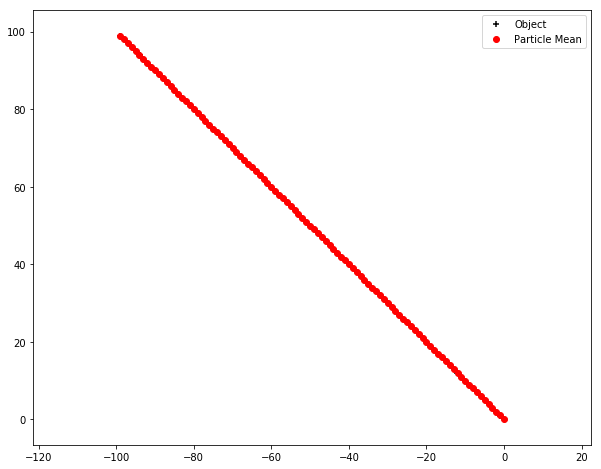

Final location error =  0.011132280257969062
Final variance in particle location =  [2.49518825e-05 2.39597751e-05]


In [137]:
'''
A particle filter created to estimate the location of 
an object with linear motion. There is uncertainty in 
the system behaviour when we move the particles and 
there is uncertainty in the sensor when we measure
the distance between particles and the object. 

Created by Kevin Minors
'''

import numpy as np
import matplotlib.pyplot as plt
import random
from numpy.random import uniform
from numpy.random import randn
from scipy.stats import norm

def run_particle_filter(number_of_particles = 100,
                        number_of_iterations = 100,
                        initial_particle_x_range = [-1,1], # Initial range for x coordinate of particles
                        initial_particle_y_range = [-1,1], # Initial range for y coordinate of particles
                        initial_object_location = [0,0], 
                        object_location_change = [-1,1], # How the object's x and y coordinates increment each iteration
                        sensor_std = .01,
                        particle_std = .01):

    '''
    Create an empty array for the particle weights and 
    the location of each particle, storing x coordinates 
    in column 0, y coordinates in column 1. Create empty
    array to hold particle indexes for resampling. Distribute 
    the locations uniformly over the initial x and y range.
    '''
    particle_weights = np.ones(number_of_particles)
    particle_locations = np.empty((number_of_particles, 2))
    particle_indexes = np.zeros(number_of_particles, 'i')
    
    particle_locations[:, 0] = uniform(initial_particle_x_range[0], 
                              initial_particle_x_range[1], 
                              size = number_of_particles)
    
    particle_locations[:, 1] = uniform(initial_particle_y_range[0], 
                              initial_particle_y_range[1], 
                              size = number_of_particles)
    
    '''
    Set the current object location to the initial object 
    location. The object_location variable changes with
    each iteration.
    
    Define arrays to store the mean location of the particles
    and the object locations as the filter iterates. Calculate 
    the initial mean of the particle locations and store it.
    Store the initial object location.  
    '''
    object_location = [initial_object_location[0], initial_object_location[1]]
    
    particle_means = np.zeros((number_of_iterations,2))
    object_locations = np.zeros((number_of_iterations,2))
    
    mean = np.average(particle_locations, weights=particle_weights, axis=0)
    
    particle_means[0,:] = [mean[0],mean[1]]
    object_locations[0,:] = [object_location[0],object_location[1]]

    for iteration in range(number_of_iterations-1):
        
        '''
        Increment the object location and store the new
        location. Increment the particle locations using 
        object movement behaviour with some uncertainty
        applied by the particle_std.
        '''
        object_location[0] += object_location_change[0]
        object_location[1] += object_location_change[1]
        object_locations[iteration+1,:] = [object_location[0],object_location[1]]
        
        particle_locations[:,0] += object_location_change[0] + randn(number_of_particles)*particle_std
        particle_locations[:,1] += object_location_change[1] + randn(number_of_particles)*particle_std
        
        '''
        Measure the distance between the particles and the object
        with some uncertainty in the measurement applied by
        the sensor_std. Take the absolute value to ensure all 
        distances are positive when the sensor_std is large.
        '''
        distance_between_particles_object = abs(np.linalg.norm(particle_locations - object_location, axis=1) 
                                             + randn(number_of_particles)*sensor_std)

        '''
        Set particle weight to 1 / distance to object. 
        Add small constant to ensure no division by 0. 
        
        Then carry out a systematic resampling based on the
        particle weights. Generate random offset in (0,1)
        and then calculate a partition of (0,1) with 
        as many subdivisions as there are particles.
        Calculate cumulative sum of particle weights. 
        '''   
        particle_weights = 1. / (distance_between_particles_object + 1.e-300)
        
        # Possible to add in if statement to only resample when weights are small enough
        random_offset = random.random()
        random_partition = [ (x + random_offset) / number_of_particles for x in list(range(number_of_particles))]

        cumulative_sum = np.cumsum(particle_weights) / sum(particle_weights)

        '''
        Reset loop variables. If the location of the partition
        is within the cumsum of a particular particle, add that
        particle's index to the resampling array and increment
        to the next partition. If not, increment to the next 
        particle in the cumsum. Particles with larger weights
        are resampled more often.
        
        Resample particles and weights using the newly
        calculated indexes. 
        '''
        i, j = 0, 0
        
        while i < number_of_particles:
            
            if random_partition[i] < cumulative_sum[j]:
                
                particle_indexes[i] = j
                i += 1
                
            else:
                
                j += 1
        
        particle_locations[:] = particle_locations[particle_indexes]
        particle_weights[:] = particle_weights[particle_indexes]
            
        '''
        Calculate the mean and variance of the particle locations. 
        Store the mean.
        '''
        mean = np.average(particle_locations, weights=particle_weights, axis=0)
        variance  = np.average((particle_locations - mean)**2, weights=particle_weights, axis=0)
        
        particle_means[iteration+1,:] = [mean[0],mean[1]]
        
    # Plot everything
    plt.figure()
    plt.scatter(object_locations[:,0], object_locations[:,1], color = 'k', marker = '+')
    plt.scatter(particle_means[:,0], particle_means[:,1], color = 'r', marker = 'o')
    plt.legend(['Object', 'Particle Mean'])
    plt.gca().set_aspect('equal', 'datalim')
    plt.gcf().set_size_inches(10, 8)
    plt.show()
    
    print('Final location error = ', np.linalg.norm(mean - object_location, axis=0))
    print('Final variance in particle location = ', variance)

run_particle_filter()